# **Fine-tune YOLOv12 Model - Calory Dataset (Object Detection)**

## Capstone Project Modul 4 | AI Engineering - Purwadhika

**Purpose:** Training dan Fine-tune YOLOv12 untuk deteksi objek makanan serta hitung estimasi kalori per gambar, lalu export best model untuk digunakan di aplikasi berbasis Streamlit.

**By:** Christopher Daniel S

## Pemilihan Algoritma Model

Pada Project ini, digunakan model **YOLOv12** karena model ini cepat, efisien, dan sangat cocok untuk dataset berukuran kecil seperti **Calory Dataset (974 gambar)**. YOLO bekerja dengan pendekatan *one-stage detection* yang memungkinkan proses deteksi real-time dan mudah diintegrasikan ke aplikasi **Streamlit**. Selain itu, YOLOv12 mendukung **transfer learning**, sehingga mampu mencapai akurasi tinggi dengan waktu training yang singkat serta menyediakan mode **segmentation (mask-based)** untuk visualisasi area makanan.

Secara spesifik, akan dipilih arsitektur model **yolov12m** (Medium). Model YOLOv12 size 'm' (Medium) dipilih karena optimal antara akurasi tinggi dan kecepatan inferensi (inference speed). Ukuran ini lebih besar dari 's' (Small), sehingga mampu menangkap fitur yang lebih kompleks dalam gambar makanan, namun tetap jauh lebih ringan dan cepat dibandingkan model 'l' (Large) atau 'x' (Extra-Large).

Algoritma model berbasis **Transformer** seperti **DETR** dalam case ini tidak digunakan, karena membutuhkan data dalam jumlah besar, waktu training yang lebih lama, dan sumber daya GPU yang lebih kuat. Karena aplikasi Calory Dataset ini perlu efisiensi, kecepatan inferensi, dan kemudahan deployment, **YOLOv12 dipilih** untuk mencapai keseimbangan antara akurasi, kecepatan dan performance.

## Informasi Dataset
- Informasi dataset (jumlah gambar, preprocessing) dari file README.
- Deskripsi dan Mapping kalori dari calory food dataset.

In [1]:
DATASET_INFO = {
    'images': 974,
    'img_size': (640,640),
    'format': 'yolo',
}
# Mapping kelas
CLASS_CALORIES = {
    'Ayam Goreng': 260,  # per 100 gr
    'Capcay': 67,        # per 100 gr
    'Nasi': 129,         # per 100 gr
    'Sayur bayam': 36,   # per 100 gr
    'Sayur kangkung': 98,# per 100 gr
    'Sayur sop': 22,     # per 100 gr
    'Tahu': 80,          # per 100 gr
    'Telur Dadar': 93,   # per 100 gr
    'Telur Mata Sapi': 110, # per butir
    'Telur Rebus': 78,   # per butir
    'Tempe': 225,        # per 100 gr
    'Tumis buncis': 65,  # per 100 gr
    'food-z7P4': 0       # placeholder
}
DATASET_INFO, CLASS_CALORIES

({'images': 974, 'img_size': (640, 640), 'format': 'yolo'},
 {'Ayam Goreng': 260,
  'Capcay': 67,
  'Nasi': 129,
  'Sayur bayam': 36,
  'Sayur kangkung': 98,
  'Sayur sop': 22,
  'Tahu': 80,
  'Telur Dadar': 93,
  'Telur Mata Sapi': 110,
  'Telur Rebus': 78,
  'Tempe': 225,
  'Tumis buncis': 65,
  'food-z7P4': 0})

## 1) Install Dependencies

Pertama, perlu Install required packages: `ultralytics`, `supervision`, `albumentations`.

In [2]:
!pip install -qU ultralytics supervision albumentations opencv-python-headless matplotlib seaborn pycocotools

import ultralytics, supervision, albumentations, cv2, matplotlib
print('ultralytics', ultralytics.__version__)
print('supervision', supervision.__version__)
print('albumentations', albumentations.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 86.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
ultralytics 8.3.226
supervision 0.26.1
albumentations 2.0.8


Notes: `supervision` memudahkan pembuatan visualisasi bounding box, confusion matrix, dan evaluasi mAP. `albumentations` dipilih karena efisien untuk augmentasi photometric (brightness/contrast, HSV, noise) tanpa mengubah geometri gambar.

## 2) Cek Ketersediaan GPU & Environment

In [3]:
# Pastikan GPU tersedia di Colab
!nvidia-smi

import torch
print('torch.cuda.is_available():', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))

Sun Nov  9 07:09:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 3) Setup Working Directory & Mount Google Drive
Mount Google Drive dan buat folder kerja `/content/drive/MyDrive/capstone_module4/`.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
WORKDIR = '/content/drive/MyDrive/Dokumen/AI ENGINEERING - PURWADHIKA/Capstone Project - Food Calory Detection'
os.makedirs(WORKDIR, exist_ok=True)
os.chdir(WORKDIR)
print('Working directory:', os.getcwd())

Mounted at /content/drive
Working directory: /content/drive/MyDrive/Dokumen/AI ENGINEERING - PURWADHIKA/Capstone Project - Food Calory Detection


Struktur direktori folder:
- `data/`  → dataset (train/val/test images & labels)
- `runs/`  → hasil training otomatis oleh Ultralytics
- `weights/` → menyimpan best.pt / last.pt secara manual
- `exports/` → model yang diexport (onnx, torchscript, etc.)


## 4) Persiapan & Upload Dataset
Upload file ZIP dataset (`Calory.v1i.yolov12.zip`) ke Google Drive kemudian unzip ke folder.

In [ ]:
# Path File Dataset ZIP di Drive
DRIVE_ZIP = "/content/drive/MyDrive/Dokumen/AI ENGINEERING - PURWADHIKA/Capstone Project - Food Calory Detection/Calory.v1i.yolov12.zip"
DATA_ROOT = os.path.join(WORKDIR)
os.makedirs(os.path.dirname(DATA_ROOT), exist_ok=True)

if os.path.exists(DRIVE_ZIP):
    !unzip -q "{DRIVE_ZIP}" -d "{os.path.dirname(DATA_ROOT)}"
    print('Dataset di-unzip ke', os.path.dirname(DATA_ROOT))
else:
    print('File ZIP dataset tidak ditemukan di', DRIVE_ZIP)

Dataset di-unzip ke /content/drive/MyDrive/Dokumen/AI ENGINEERING - PURWADHIKA/Capstone Project - Food Calory Detection


In [6]:
# Tampilkan ringkasan struktur folder
if os.path.exists(DATA_ROOT):
    for split in ['train', 'valid', 'test']:
        img_dir = os.path.join(DATA_ROOT, split, 'images')
        lbl_dir = os.path.join(DATA_ROOT, split, 'labels')
        print(split, 'images:', len(os.listdir(img_dir)) if os.path.exists(img_dir) else 0,
              'labels:', len(os.listdir(lbl_dir)) if os.path.exists(lbl_dir) else 0)

train images: 721 labels: 721
valid images: 147 labels: 147
test images: 106 labels: 106


In [7]:
# Tampilkan data.yaml
data_yaml_path = "/content/drive/MyDrive/Dokumen/AI ENGINEERING - PURWADHIKA/Capstone Project - Food Calory Detection/data.yaml"

if os.path.exists(data_yaml_path):
    print('---- data.yaml ----')
    with open(data_yaml_path) as f:
        print(f.read())
else:
    print('data.yaml tidak ditemukan di', data_yaml_path)

---- data.yaml ----
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 13
names: ['Ayam Goreng -260 kal per 100 gr-', 'Capcay -67 kal per 100gr-', 'Nasi -129 kal per 100gr-', 'Sayur bayam -36 kal per 100gr-', 'Sayur kangkung -98 kal per 100gr-', 'Sayur sop -22 kal per 100gr-', 'Tahu -80 kal per 100 gr-', 'Telur Dadar -93 kal per 100gr-', 'Telur Mata Sapi -110kal1butir-', 'Telur Rebus -78kal 1butir-', 'Tempe -225 kal per 100 gr-', 'Tumis buncis -65 kal per 100gr-', 'food-z7P4']

roboflow:
  workspace: ayu-asipq
  project: calory
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/ayu-asipq/calory/dataset/1


Penjelasan `data.yaml`:
- `train`, `val`, `test` = path ke direktori gambar
- `nc` = jumlah kelas
- `names` = daftar nama kelas


## 5) Exploratory Data Analysis (Visualisasi Sample Images & Label Checks)

Visualisasikan beberapa images dengan bounding box dari YOLO Labels.

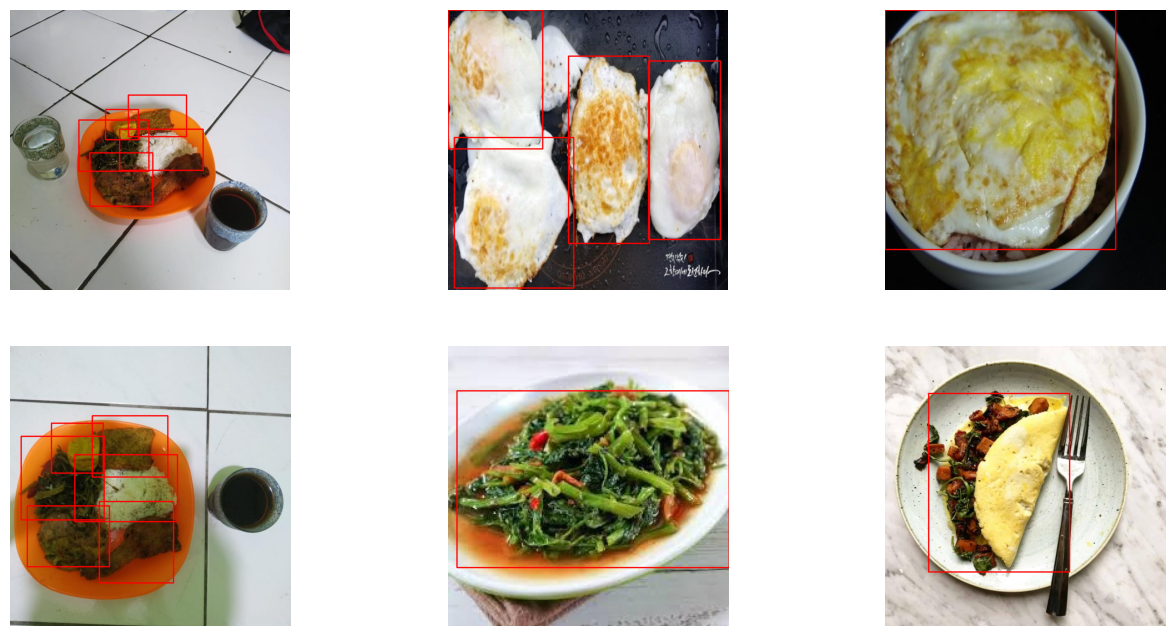

In [ ]:
import random, glob
import cv2
import matplotlib.pyplot as plt
import supervision as sv

def show_random_samples(images_dir, labels_dir, n=6):
    image_paths = glob.glob(images_dir + '/*')
    samples = random.sample(image_paths, min(n, len(image_paths)))
    plt.figure(figsize=(16,8))
    for i, p in enumerate(samples):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        label_path = os.path.join(labels_dir, os.path.basename(p).replace('.jpg','.txt'))
        detections = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls = int(parts[0]); x = float(parts[1]); y = float(parts[2]); w = float(parts[3]); h = float(parts[4])
                        h_img, w_img = img.shape[:2]
                        xmin = int((x - w/2) * w_img); ymin = int((y - h/2) * h_img)
                        xmax = int((x + w/2) * w_img); ymax = int((y + h/2) * h_img)
                        detections.append([xmin,ymin,xmax,ymax, cls])
        ax = plt.subplot(2, int(n/2), i+1)
        ax.imshow(img); ax.axis('off')
        for d in detections:
            xmin,ymin,xmax,ymax,cls = d
            cv2.rectangle(img, (xmin,ymin),(xmax,ymax),(255,0,0),2)
        ax.imshow(img)

if os.path.exists(DATA_ROOT):
    show_random_samples(os.path.join(DATA_ROOT,'train','images'), os.path.join(DATA_ROOT,'train','labels'), n=6)
else:
    print('Dataset belum tersedia di DATA_ROOT. Jalankan cell unzip terlebih dahulu.')

In [ ]:
import pandas as pd
from collections import Counter
import os, glob

def dataset_stats(root):
    rows = []
    for split in ['train','valid','test','val']:
        img_dir = os.path.join(root, split, 'images')
        lbl_dir = os.path.join(root, split, 'labels')
        if not os.path.exists(img_dir):
            continue
        imgs = sorted(glob.glob(os.path.join(img_dir, '*')))
        counts = []
        cls_counter = Counter()
        oob = 0
        for imgp in imgs:
            lblp = os.path.join(lbl_dir, os.path.splitext(os.path.basename(imgp))[0] + '.txt')
            if not os.path.exists(lblp):
                counts.append(0)
                continue
            with open(lblp) as f:
                lines = f.read().strip().splitlines()
            counts.append(len(lines))
            for L in lines:
                parts = L.split()
                if len(parts) < 5:
                    continue
                cls = int(parts[0])
                x, y, w, h = map(float, parts[1:5])
                cls_counter[cls] += 1
                if x < 0 or x > 1 or y < 0 or y > 1 or w <= 0 or h <= 0:
                    oob += 1
        rows.append({
            'split': split,
            'images': len(imgs),
            'objects': sum(counts),
            'avg_obj_per_img': (sum(counts) / len(imgs)) if imgs else 0,
            'out_of_bounds_labels': oob
        })
        for k, v in cls_counter.items():
            rows.append({'split': split, 'class': k, 'count': v})
    return pd.DataFrame(rows)

# Tampilkan dataframe langsung tanpa caas_jupyter_tools
if os.path.exists(DATA_ROOT):
    stats = dataset_stats(DATA_ROOT)
    print("Ringkasan dataset:")
    display(stats.head(20))  # tampilkan 20 baris pertama
else:
    print('Dataset tidak ditemukan untuk statistik.')


Ringkasan dataset:


,split,images,objects,avg_obj_per_img,out_of_bounds_labels,class,count
0,train,721.0,1296.0,1.797503,0.0,NaN,NaN
1,train,NaN,NaN,NaN,NaN,4.0,121.0
2,train,NaN,NaN,NaN,NaN,7.0,217.0
3,train,NaN,NaN,NaN,NaN,10.0,224.0
4,train,NaN,NaN,NaN,NaN,6.0,90.0
5,train,NaN,NaN,NaN,NaN,0.0,90.0
6,train,NaN,NaN,NaN,NaN,2.0,85.0
7,train,NaN,NaN,NaN,NaN,8.0,229.0
8,train,NaN,NaN,NaN,NaN,5.0,10.0
9,train,NaN,NaN,NaN,NaN,11.0,22.0


## 6) Preprocessing & Augmentation
Dilakukan photometric augmentations pada dataset.

Contoh augmentasi:


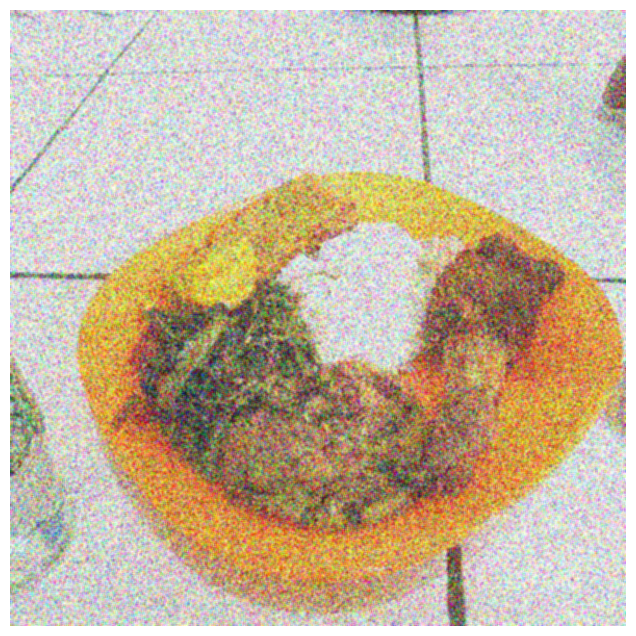

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

augmenter = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.4),
    A.GaussNoise(p=0.2),
    A.Blur(blur_limit=3, p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

print('Contoh augmentasi:')
if os.path.exists(DATA_ROOT):
    sample_img = glob.glob(os.path.join(DATA_ROOT,'train','images','*'))[0]
    img = cv2.cvtColor(cv2.imread(sample_img), cv2.COLOR_BGR2RGB)
    sample_lbl = os.path.join(DATA_ROOT,'train','labels', os.path.basename(sample_img).replace('.jpg','.txt'))
    bboxes=[]; labels=[]
    if os.path.exists(sample_lbl):
        with open(sample_lbl) as f:
            for line in f:
                p=line.split(); labels.append(int(p[0])); bboxes.append([float(p[1]),float(p[2]),float(p[3]),float(p[4])])
    augmented = augmenter(image=img, bboxes=bboxes, class_labels=labels)
    plt.figure(figsize=(8,8)); plt.imshow(augmented['image']); plt.axis('off')
else:
    print('Dataset tidak ada - lewati contoh augmentasi')


Pilihan augmentasi dapat di-implementasikan melalui `albumentations` atau menggunakan parameter `augment` di `model.train()` dari Ultralytics. Pada dataset ini rekomendasi: photometric-heavy augmentations dan ringan pada geometric.


## 7) Buat/Periksa File `data.yaml` dan Pretrained Weights
Pastikan `data.yaml` berisi path yang benar untuk train/val/test, `nc`, dan `names`.
Download pretrained weights yolov12m. Digunakan model `yolov12m.pt` untuk akurasi yang lebih baik dibanding `yolov12n` dan `yolov12s`.

In [ ]:
# Download Model yolov12m
!wget -q --show-progress https://github.com/sunsmarterjie/yolov12/releases/download/v1.0/yolov12m.pt -O yolov12m.pt || true
print('yolov12m.pt tersedia' if os.path.exists('yolov12m.pt') else 'yolov12m.pt tidak ditemukan')

yolov12m.pt         100%[===================>]  39.01M  59.3MB/s    in 0.7s    
yolov12m.pt tersedia


## 8) Inisialisasi Model YOLOv12

In [15]:
from ultralytics import YOLO
model = YOLO('yolov12m.pt')
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_

## 9) Konfigurasi Hyperparameter & Training Strategy
Digunakan hyperparameter berikut untuk akurasi yang baik:
- `epochs`: 100
- `batch`: 16
- `imgsz`: 640
- `lr`: 0.001 (stabil untuk Adam)
- `patience`: 25
- `save_period`: 5

In [ ]:
# Hyperparameter yang digunakan
TRAIN_PARAMS = dict(
    data = os.path.join(DATA_ROOT, 'data.yaml'),
    epochs = 100,
    batch = 16,
    imgsz = 640,
    lr0 = 0.001,
    patience = 25,
    save_period = 5,
    exist_ok = True,
    val = True,
    verbose = True,
)
TRAIN_PARAMS

{'data': '/content/drive/MyDrive/Dokumen/AI ENGINEERING - PURWADHIKA/Capstone Project - Food Calory Detection/data.yaml',
 'epochs': 100,
 'batch': 16,
 'imgsz': 640,
 'lr0': 0.001,
 'patience': 25,
 'save_period': 5,
 'exist_ok': True,
 'val': True,
 'verbose': True}

## 10) Training Model YOLOv12
Jalankan `model.train()` dengan parameter sebelumnya. Hasil akan disimpan di `runs/detect/train` oleh Ultralytics.

In [ ]:
if os.path.exists(TRAIN_PARAMS['data']):
    results = model.train(**TRAIN_PARAMS)
    print('Training selesai')
else:
    print('data.yaml tidak ditemukan, pastikan DATA_ROOT diarahkan ke folder dataset yang benar')

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Dokumen/AI ENGINEERING - PURWADHIKA/Capstone Project - Food Calory Detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov12m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, o

Setelah training selesai, model akan menyimpan `best.pt` dan `last.pt` di folder runs/detect/train/weights (atau path serupa).

## 11) Visualisasi Hasil Training

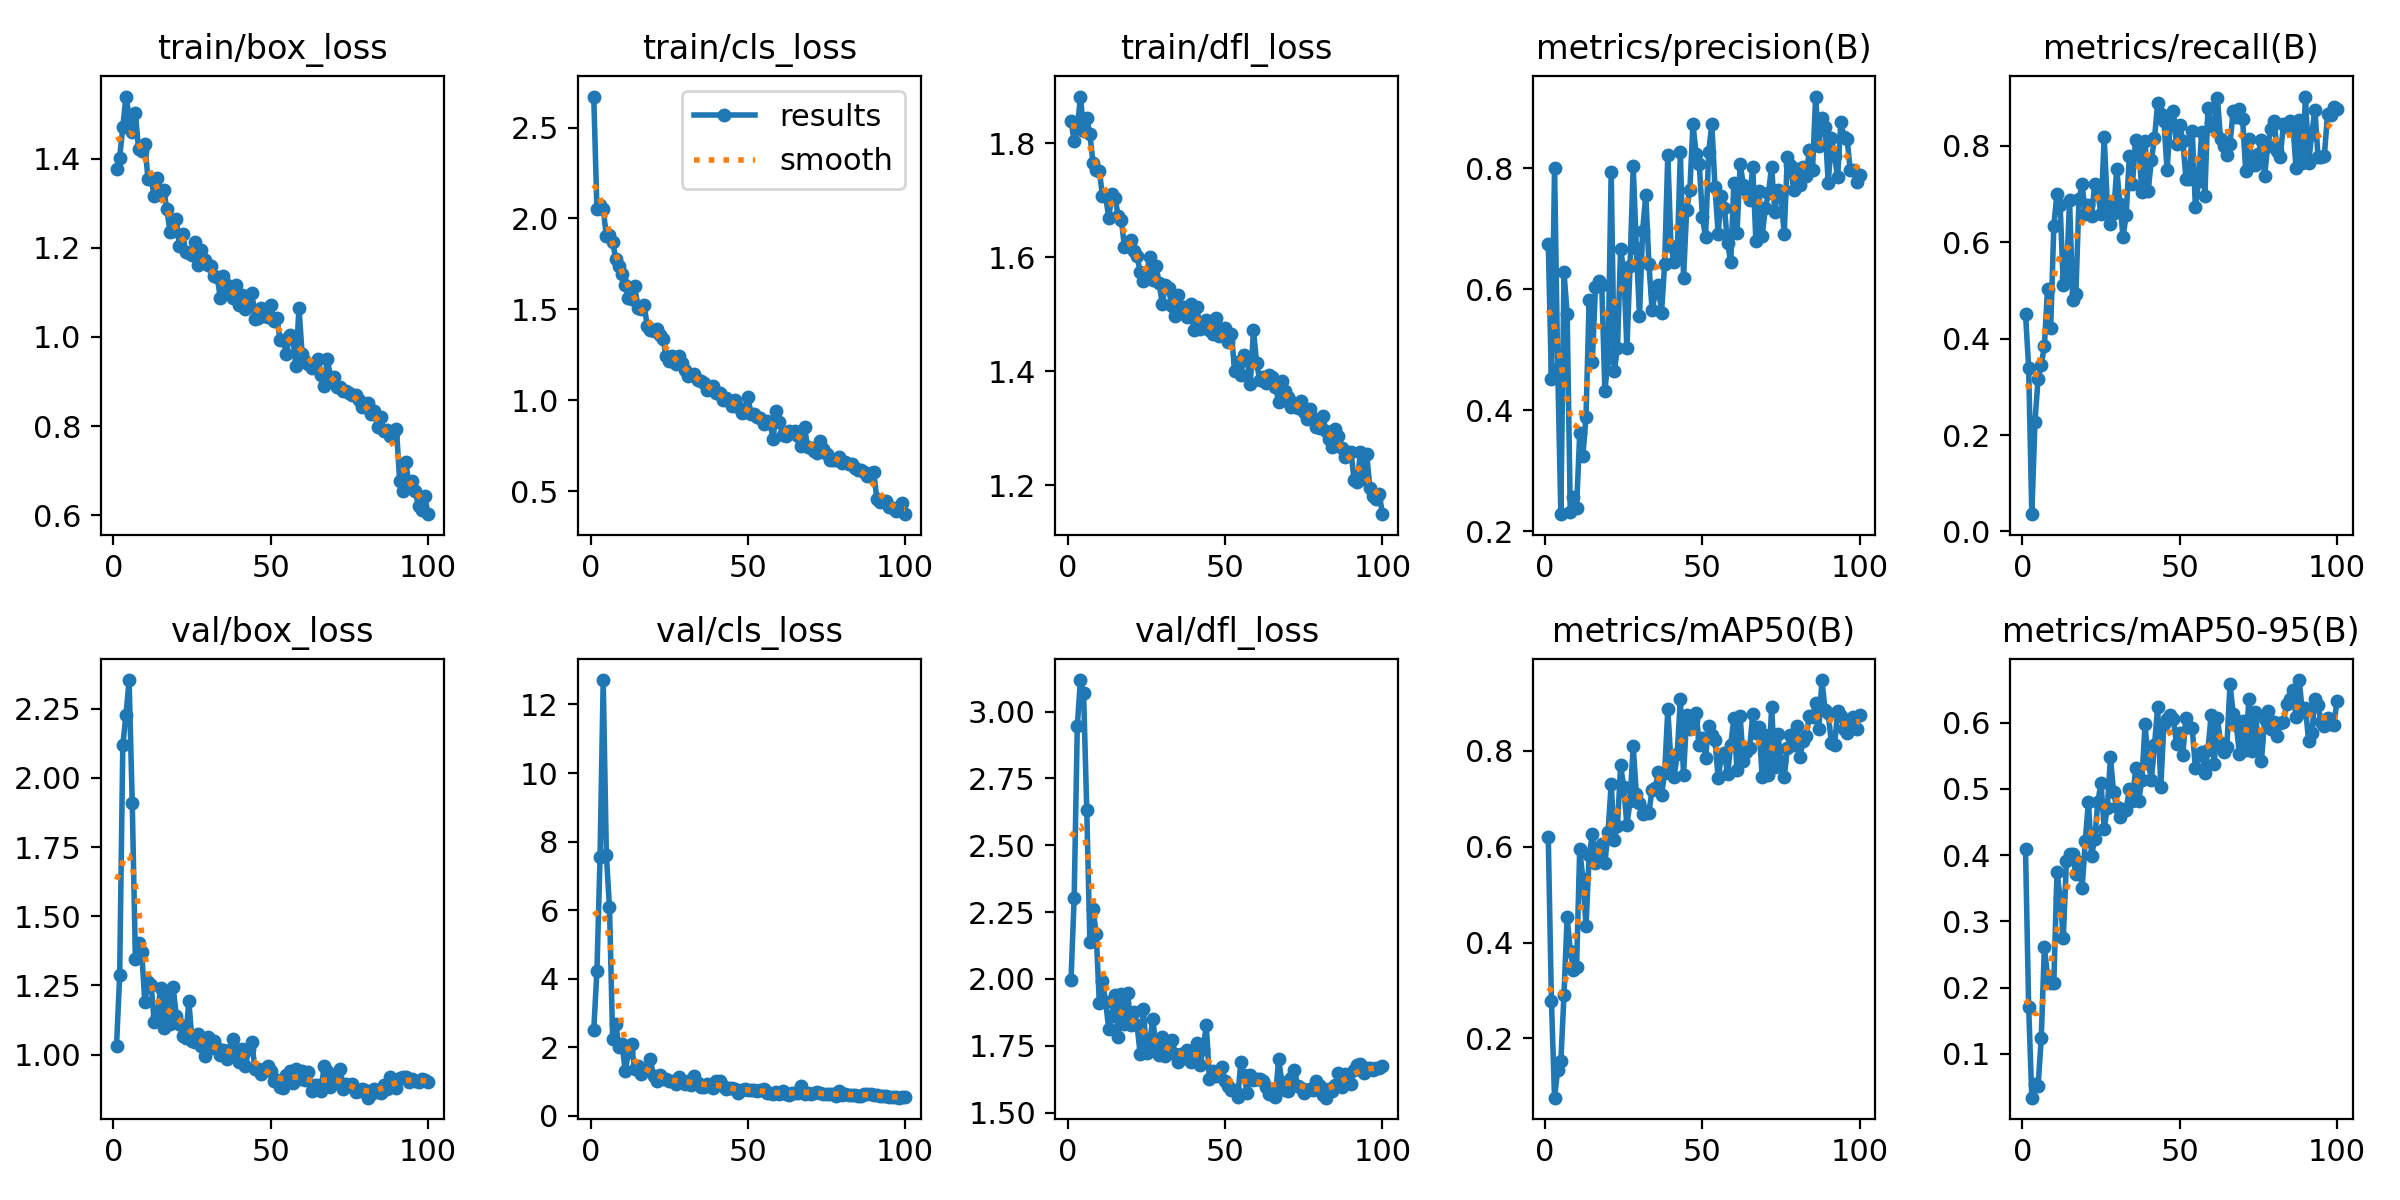

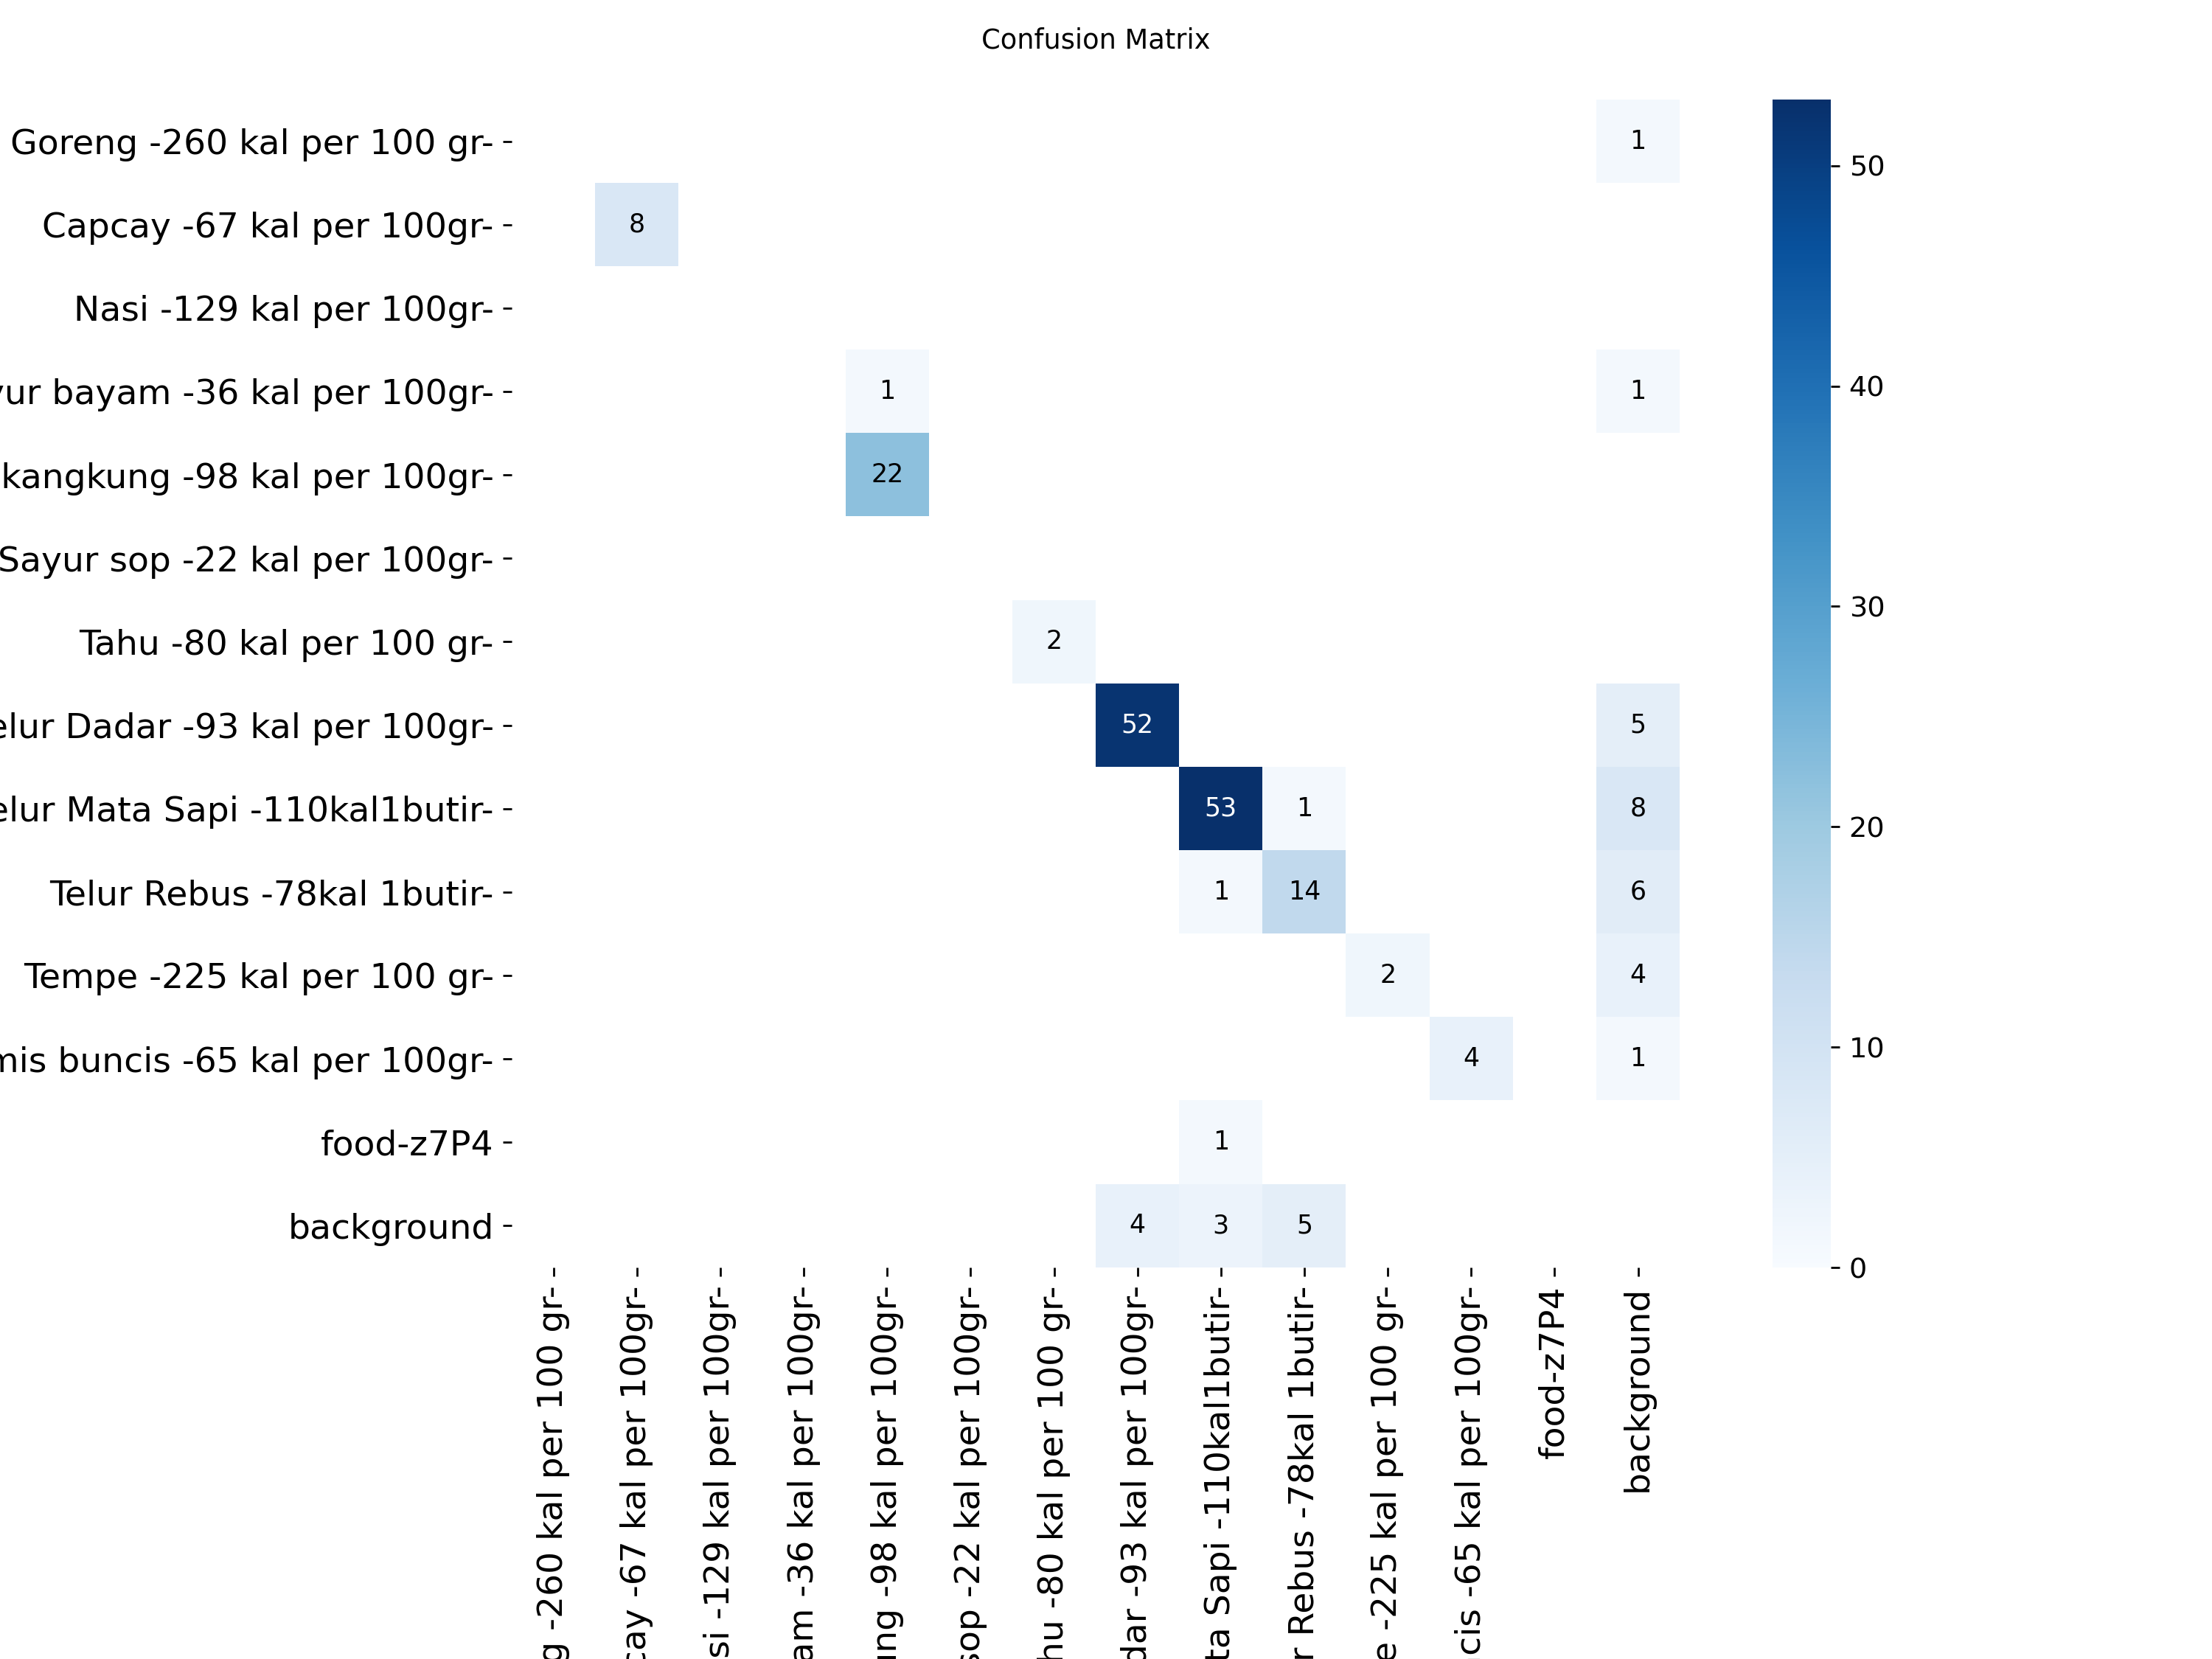

In [ ]:
from IPython.display import Image, display
import glob
run_dir = 'runs/detect/train'
if os.path.exists(run_dir):
    for fname in ['results.png','confusion_matrix.png']:
        p = os.path.join(run_dir, fname)
        if os.path.exists(p):
            display(Image(p))
else:
    print('belum ada run output, jalankan training dulu')

Hasil *confusion matrix* menunjukkan bahwa model **YOLOv12m** telah berhasil mengenali sebagian besar kelas makanan dengan akurasi yang cukup baik, khususnya pada kelas **Telur Dadar** dan **Telur Mata Sapi**, yang memiliki jumlah prediksi benar tertinggi (diagonal bernilai >50). Hal ini menandakan model mampu belajar fitur visual khas dari kedua kelas tersebut secara konsisten. Kelas lain seperti **Sayur Kangkung**, **Telur Rebus**, dan **Tempe** juga menunjukkan performa yang stabil dengan prediksi yang relatif akurat meskipun jumlah datanya lebih sedikit.  

Namun, terdapat beberapa kelas dengan *misclassification* yang masih tinggi seperti **Capcay**, **Sayur Sop**, dan **Tumis Buncis**, yang kemungkinan besar disebabkan oleh kemiripan visual antar sayur atau pencahayaan yang bervariasi pada dataset. Kelas *placeholder* seperti `food-z7P4` juga tampak membingungkan model karena tidak memiliki label semantik yang jelas. Secara keseluruhan, hasil ini menunjukkan model sudah cukup terlatih untuk mendeteksi objek makanan utama, tetapi dapat ditingkatkan lagi melalui augmentasi data tambahan atau *class balancing* untuk mengurangi kesalahan antar kelas sayuran yang serupa.


## 12) Evaluasi Objektif (mAP) & Evaluasi Domain (Kalori)

In [16]:
from supervision.metrics import MeanAveragePrecision
import numpy as np

# Load test dataset for supervision
if os.path.exists(DATA_ROOT):
    ds = sv.DetectionDataset.from_yolo(
        images_directory_path=os.path.join(DATA_ROOT,'test','images'),
        annotations_directory_path=os.path.join(DATA_ROOT,'test','labels'),
        data_yaml_path=os.path.join(DATA_ROOT,'data.yaml')
    )
    print('Dataset test loaded, num samples:', len(ds))
else:
    print('Test dataset tidak ditemukan')

# Evaluate mAP
best_weights = os.path.join('runs','detect','train','weights','best.pt')
if os.path.exists(best_weights):
    eval_model = YOLO(best_weights)
    predictions = []
    targets = []
    for _, image, target in ds:
        results = eval_model(image, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        predictions.append(detections)
        targets.append(target)
    mAP = MeanAveragePrecision().update(predictions, targets).compute()
    print('mAP 50:', mAP.map50, 'mAP 50:95:', mAP.map50_95, 'mAP 75:', mAP.map75)
else:
    print('best.pt tidak ditemukan, jalankan training terlebih dahulu')

Dataset test loaded, num samples: 106
mAP 50: 0.8193477098887283 mAP 50:95: 0.5711515092014481 mAP 75: 0.6754503352867538


Hasil evaluasi menunjukkan performa deteksi yang **cukup baik** dengan nilai :

*   **mAP@50 sebesar 0.82**
*   **mAP@75 sebesar 0.68**
*   **mAP@50-95 sebesar 0.57**

Setelah diuji pada test dataset yang berisi 106 sampel gambar. Nilai **mAP@50 di atas 0.8** menandakan bahwa model mampu melakukan deteksi objek dengan akurasi tinggi pada ambang IoU yang longgar, sementara **mAP@75** yang stabil menunjukkan model masih menjaga presisi yang baik meski pada ambang deteksi yang lebih ketat. Secara umum, hasil ini menggambarkan bahwa model **YOLOv12m** telah belajar dengan efektif dan memiliki kemampuan generalisasi yang memadai terhadap test dataset.

Beberapa kemungkinan *next improvement* yang dapat dilakukan untuk meningkatkan **mAP@50-95** (yang mengukur kinerja di berbagai ambang IoU) antara lain:  
- Menambah variasi data melalui **augmentasi photometric dan geometric** untuk memperluas distribusi visual.  
- Melakukan **class rebalancing** agar kelas dengan jumlah sampel kecil tidak terabaikan saat training.  
- Memanfaatkan **fine-tuning tambahan** dengan *learning rate decay* atau *early stopping* untuk mengoptimalkan konvergensi model.  
Secara keseluruhan, performa ini sudah cukup akurat untuk digunakan dalam tahap **deployment** ke aplikasi Streamlit dengan tingkat kinerja deteksi yang cukup tinggi.


## 13) Inference Contoh & Visualisasi

--- HASIL DETEKSI DAN ESTIMASI KALORI ---
File: Img_099_0432_jpg.rf.622c3486181019935df98dc584eb9f0d.jpg
Makanan yang terdeteksi:
- Telur Mata Sapi - 110 kal - (~110 kal) [Conf: 0.89]
- Telur Mata Sapi - 110 kal - (~110 kal) [Conf: 0.81]
-----------------------------------------
TOTAL ESTIMASI KALORI: 220 kal

--- Gambar Hasil Anotasi ---


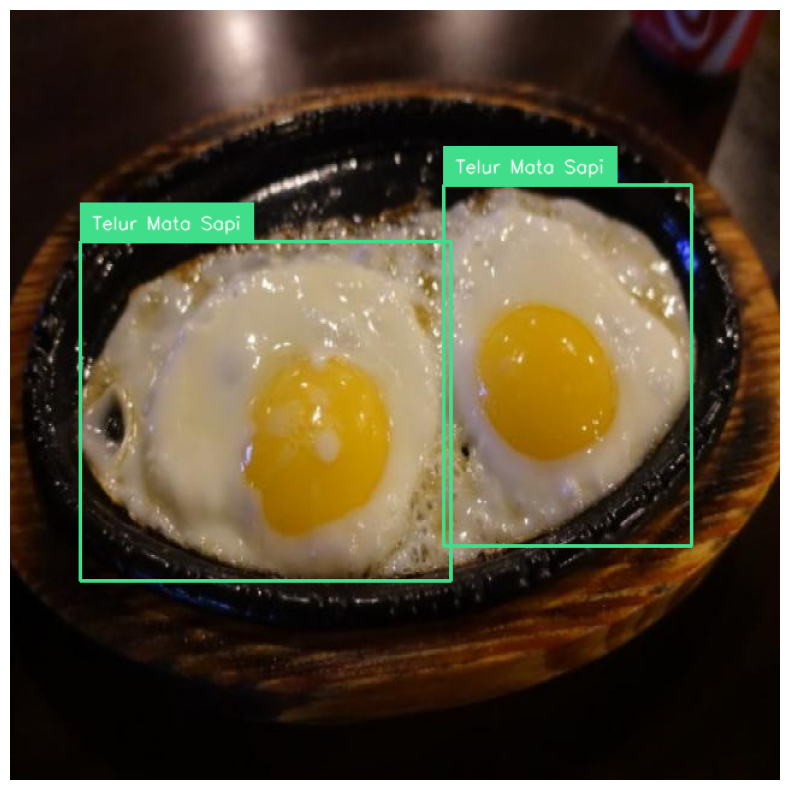

In [77]:
import random
import re

if os.path.exists(best_weights) and os.path.exists(DATA_ROOT):
    sample_idx = random.randint(0, len(ds)-1)
    image_path, image, target = ds[sample_idx]
    res = eval_model(image, verbose=False)[0]
    det = sv.Detections.from_ultralytics(res).with_nms()

    # --- Hasil Summary Detection ---
    print("--- HASIL DETEKSI DAN ESTIMASI KALORI ---")
    print(f"File: {os.path.basename(image_path)}")
    print("Makanan yang terdeteksi:")
    total_calories = 0

    calorie_pattern = re.compile(r'-(\d+)\s*kal\s*(.*?)-')

    # Iterate through detections to print summary and calculate total calories
    for class_id, confidence in zip(det.class_id, det.confidence):
        full_class_name = ds.classes[int(class_id)] # e.g., 'Ayam Goreng -260 kal per 100 gr-'

        food_item_name = full_class_name.split(' -')[0] # e.g., 'Ayam Goreng'
        calories = 0
        unit = "N/A"

        match = calorie_pattern.search(full_class_name)
        if match:
            calories = int(match.group(1))
            unit = match.group(2).strip() # Remove leading/trailing spaces

        total_calories += calories
        print(f"- {food_item_name} - {calories} kal - (~{calories} kal) [Conf: {confidence:.2f}]")

    print("-----------------------------------------")
    print(f"TOTAL ESTIMASI KALORI: {total_calories} kal")
    print("\n--- Gambar Hasil Anotasi ---")
    # --- End of summary section ---

    # annotate
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    # Re-parse calorie and unit for image labels as well
    image_labels = []
    for class_id, confidence in zip(det.class_id, det.confidence):
        full_class_name = ds.classes[int(class_id)]
        food_item_name = full_class_name.split(' -')[0]
        image_labels.append(f"{food_item_name}")

    annotated = box_annotator.annotate(image.copy(), det)
    # Pass the generated labels to the annotator to display them
    annotated = label_annotator.annotate(annotated, det, labels=image_labels)
    plt.figure(figsize=(10,10)); plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
else:
    print('Inference tidak dilakukan karena model atau dataset tidak tersedia')

## 14) Export Model untuk Deployment
Export model `best.pt` ke ONNX and TorchScript untuk Streamlit deployment.

In [ ]:
# Export model
import os, glob, shutil
from ultralytics import YOLO

# WORKDIR dan export_dir didefinisikan
WORKDIR = os.getcwd() if 'WORKDIR' not in globals() else WORKDIR
export_dir = os.path.join(WORKDIR, 'exports'); os.makedirs(export_dir, exist_ok=True)

# Path ke best weights
best_weights = os.path.join('runs','detect','train','weights','best.pt')
if not os.path.exists(best_weights):
    print("best.pt tidak ditemukan di", best_weights, "\nPastikan training sudah selesai dan path benar.")
else:
    # Load model dari best.pt
    model = YOLO(best_weights)
    print("Model loaded from", best_weights)

    # 1) Export dengan save_dir
    exported_files = []
    try:
        print("Mencoba export with save_dir...")
        model.export(format='onnx', imgsz=640, save_dir=export_dir)
        print("Export (save_dir) dipanggil — periksa", export_dir)
        # kumpulkan hasil .onnx
        exported_files = glob.glob(os.path.join(export_dir, "*.onnx")) + glob.glob(os.path.join(export_dir, "*.ts")) + glob.glob(os.path.join(export_dir, "*.torchscript"))
    except Exception as e1:
        print("Export dengan save_dir gagal:", str(e1))
        # 2) export tanpa file/save_dir — biarkan Ultralytics tempatkan hasil di default runs/export atau runs/detect/exp/export
        try:
            print("Mencoba export tanpa save_dir (default)...")
            model.export(format='onnx', imgsz=640)
            print("Export (default) dipanggil — mencari file hasil di folder runs/ ...")
        except Exception as e2:
            print("Export default juga gagal:", str(e2))
            print("Tidak dapat melakukan export lewat API saat ini. Cek versi ultralytics dan dokumentasi export.")
        # setelah memanggil export cari file .onnx/.ts di folder runs
        # cari di beberapa pola umum
        search_patterns = [
            os.path.join(WORKDIR, "runs", "**", "*.onnx"),
            os.path.join(WORKDIR, "runs", "**", "*.ts"),
            os.path.join(WORKDIR, "runs", "**", "*.torchscript"),
            os.path.join(WORKDIR, "**", "*.onnx"),
            os.path.join(WORKDIR, "**", "*.ts")
        ]
        found = []
        for pat in search_patterns:
            found += glob.glob(pat, recursive=True)
        exported_files = sorted(list(set(found)), key=os.path.getmtime)

    # 3) Jika ada file hasil export, pindahkan/rename ke export_dir dan tampilkan
    if exported_files:
        print("Ditemukan file export:", exported_files)
        moved = []
        for f in exported_files:
            try:
                dest = os.path.join(export_dir, os.path.basename(f))
                # jika nama sudah ada, tambahkan suffix
                if os.path.exists(dest):
                    base, ext = os.path.splitext(os.path.basename(f))
                    dest = os.path.join(export_dir, base + "_1" + ext)
                shutil.copy2(f, dest)
                moved.append(dest)
            except Exception as e:
                print("Gagal memindahkan", f, "->", str(e))
        if moved:
            print("Export selesai — file disalin ke:", export_dir)
            for m in moved:
                print(" -", m)
        else:
            print("Tidak berhasil memindahkan file export.")
    else:
        print("Tidak ditemukan file export otomatis. Jika API ultralytics versi Anda butuh argumen lain, periksa dokumentasi atau gunakan model.export(...) tanpa argumen lalu cari hasil di folder 'runs/'.")

Model loaded from runs/detect/train/weights/best.pt
Mencoba export with save_dir...
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv12m summary (fused): 169 layers, 20,114,935 parameters, 0 gradients, 67.2 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (38.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 13.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.73...
ONNX: export success ✅ 18.1s, saved as 'runs/detect/train/weights/best.onnx' (77.1 MB)

Export complete (21.9

### **Conclusion**

1.  **Performa Training Model:**
    Model berhasil dilatih selama 100 epoch, menunjukkan kurva pembelajaran yang baik dimana *loss* menurun secara konsisten dan metrik akurasi (mAP) meningkat. Hal ini mengindikasikan bahwa model mampu belajar fitur-fitur relevan dari dataset makanan yang digunakan.

2.  **Evaluasi Kuantitatif (mAP):**
    Pada *test dataset*, model mencapai performa yang sangat baik, divalidasi oleh metrik *Mean Average Precision* (mAP) berikut:
    *   **mAP@50: 0.82** (Sangat Baik): Model ini sangat akurat dalam mendeteksi objek makanan pada ambang batas IoU 0.5.
    *   **mAP@50-95: 0.57**: Menunjukkan performa yang solid di berbagai tingkat tumpang tindih bounding box.
    *   **mAP@75: 0.68**: Kemampuan deteksi tetap baik bahkan pada ambang batas yang lebih ketat.

3.  **Analisis Kualitatif:**
    *   **Kekuatan Model:** *Confusion matrix* menunjukkan bahwa model sangat andal dalam mengenali kelas-kelas dengan fitur visual yang unik, seperti **'Telur Dadar'** dan **'Telur Mata Sapi'**.
    *   **Area Peningkatan:** Terdapat sedikit kebingungan (*misclassification*) antara kelas-kelas sayuran yang mirip secara visual (misalnya, 'Capcay', 'Sayur Sop'), yang merupakan area potensial untuk perbaikan di masa depan.

### **Rekomendasi**

Berdasarkan hasil yang dicapai, model ini siap untuk deployment. Namun, beberapa langkah perbaikan dan improvement dapat diterapkan untuk berikutnya:

*   **Peningkatan Dataset:** Menambah jumlah gambar, terutama untuk kelas-kelas yang sering salah diklasifikasikan, dan menerapkan *class balancing* untuk meningkatkan akurasi pada kelas minoritas.
*   **Augmentasi Data Lanjutan:** Menggunakan teknik augmentasi yang lebih beragam untuk membantu model membedakan antara objek makanan yang serupa.
*   **Estimasi Kalori Berbasis Ukuran:** Mengembangkan metode untuk memperkirakan ukuran porsi (misalnya, berdasarkan luas *bounding box*) untuk memberikan estimasi kalori yang lebih dinamis dan akurat, tidak hanya berdasarkan jumlah deteksi.